# ABS Retail Trade 8501

## Python set-up

In [1]:
# system imports
import sys

# analytic imports
import pandas as pd
import matplotlib.pyplot as plt

# local imports
from abs_data_capture import (
    get_fs_constants,
    get_ABS_meta_and_data,
    get_plot_constants,
)
from plotting import (
    # finalise_plot,
    set_chart_dir,
    recalibrate_series,
    clear_chart_dir,
    plot_covid_recovery,
    plot_growth_finalise,
    calc_growth,
)

# pandas display settings
pd.options.display.max_rows = None
pd.options.display.max_columns = 999

# plotting stuff
plt.style.use("fivethirtyeight")

## Get data from the ABS

In [2]:
# get ABS retail data
retail_catalogue_id = "8501"
source, CHART_DIR, META_DATA = get_fs_constants(retail_catalogue_id)
retail_dict = get_ABS_meta_and_data(retail_catalogue_id)
if retail_dict is None:
    sys.exit(-1)
retail_meta = retail_dict[META_DATA]
RECENT, plot_times, plot_tags = get_plot_constants(retail_meta)

Found URL for a ZIP file on ABS web page
Retrieving zip-file from cache ...
Extracting DataFrames from the zip-file ...


## Plot - retail turnover by industry

### Plotting initialisation / constants

In [3]:
# clear the old charts
clear_chart_dir(CHART_DIR)
set_chart_dir(CHART_DIR)

# multi-line the title if might be too long.
LONG_LABEL = 30  # characters

table_col = "Table"
did_col = "Data Item Description"
type_col = "Series Type"
unit_col = "Unit"
id_col = "Series ID"

retail_type = "Seasonally Adjusted"

### Data extraction and plotting functions

In [4]:
def fix_title(title: str, lfooter: str) -> tuple[str, str]:
    check = [
        "Chain Volume Measures",
        "Chain Volume Measure",
        "Current Prices",
        "Current Price",
        "Total (State)",
        "Total (Industry)",
    ]
    for c in check:
        if c in title:
            title = title.replace(f"{c} ;", "")
            lfooter += f"{c}. "

    states = {
        "New South Wales": "NSW",
        "Victoria": "Vic.",
        "Queensland": "Qld.",
        "South Australia": "SA",
        "Western Australia": "WA",
        "Tasmania": "Tas.",
        "Northern Territory": "NT",
        "Australian Capital Territory": "ACT",
    }
    for s, abbr in states.items():
        title = title.replace(s, abbr)

    title = (
        title.replace(";", "")
        .replace(" - ", " ")
        .replace("    ", " ")
        .replace("   ", " ")
        .replace("  ", " ")
        .strip()
    )
    return title, lfooter

### Main plotting loop

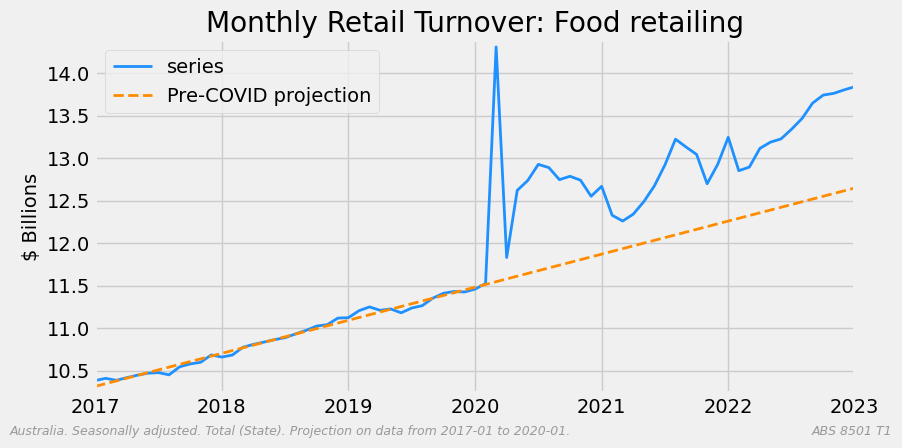

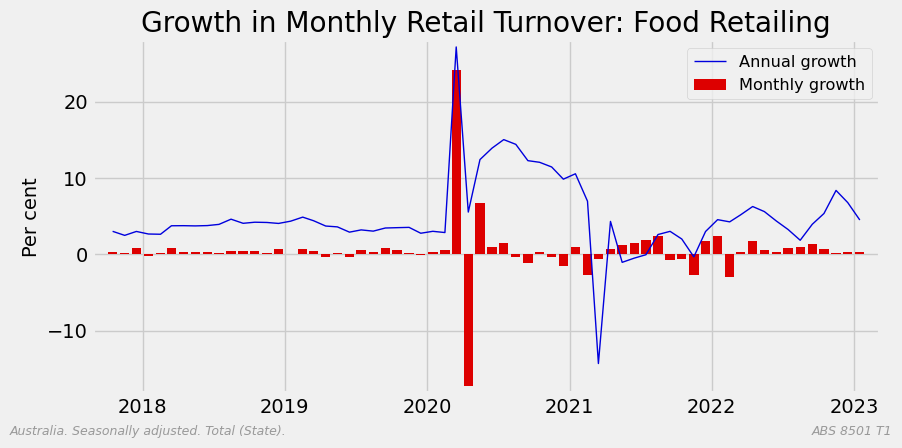

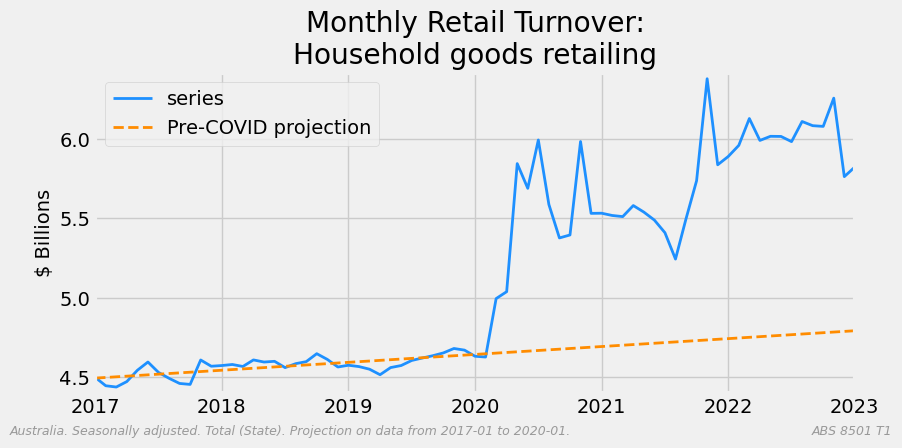

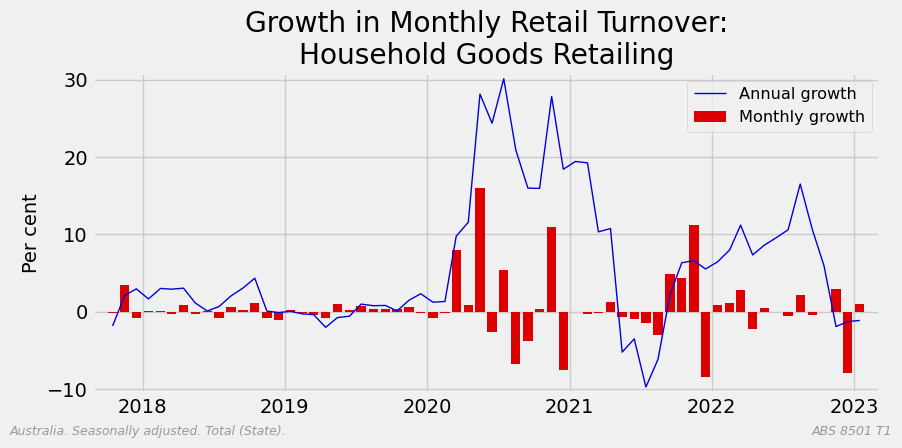

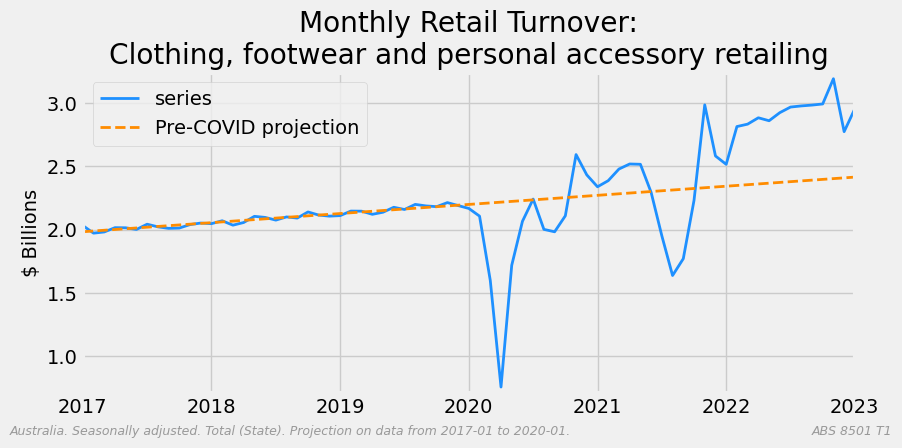

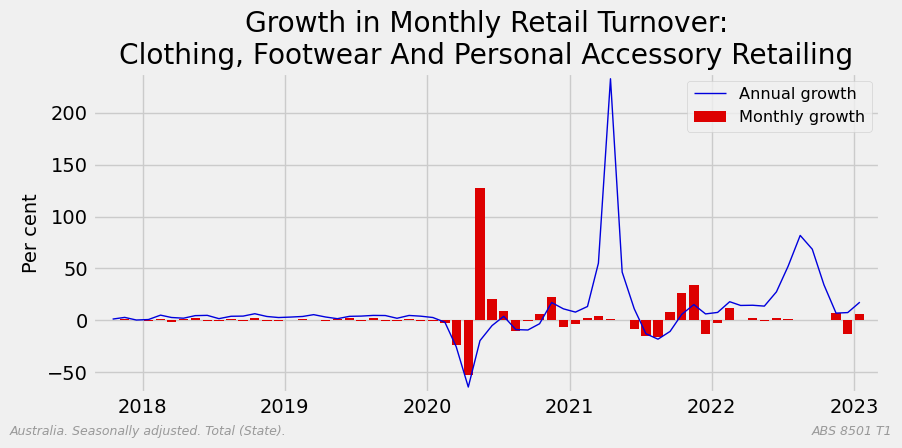

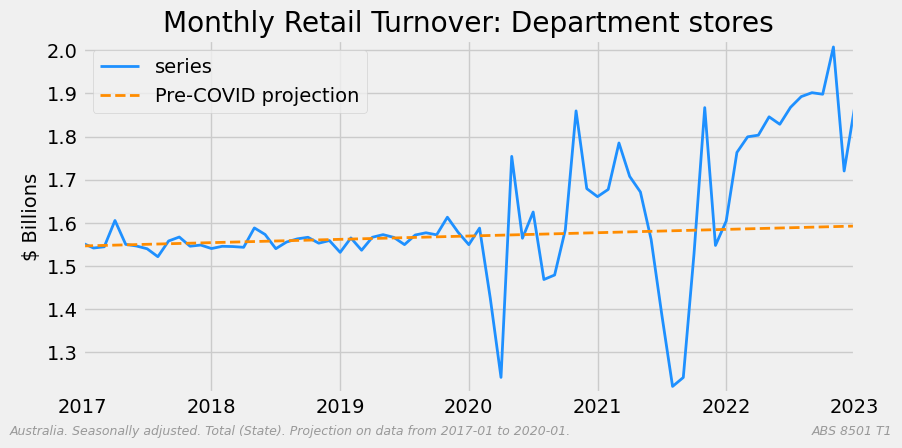

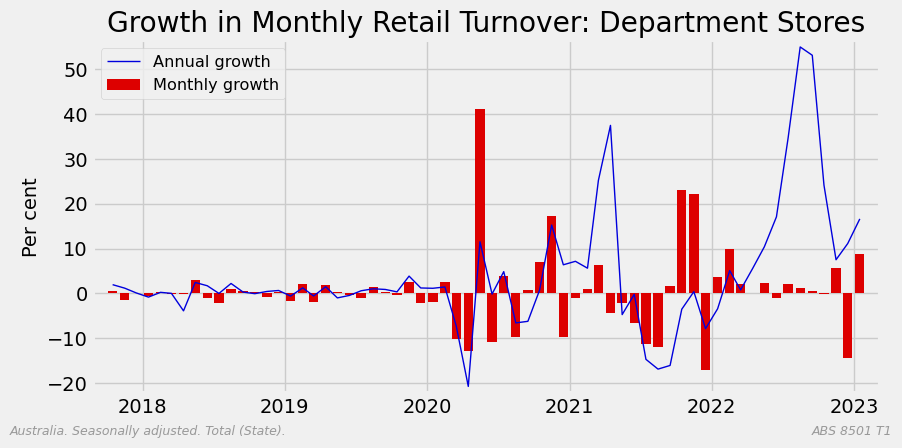

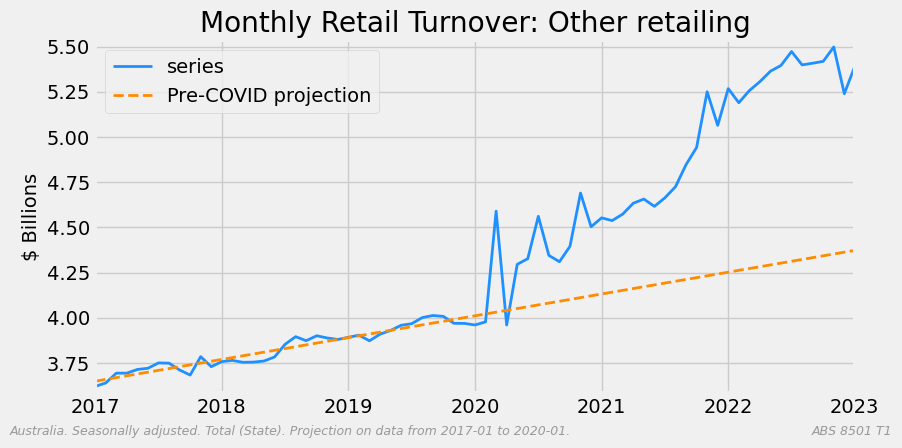

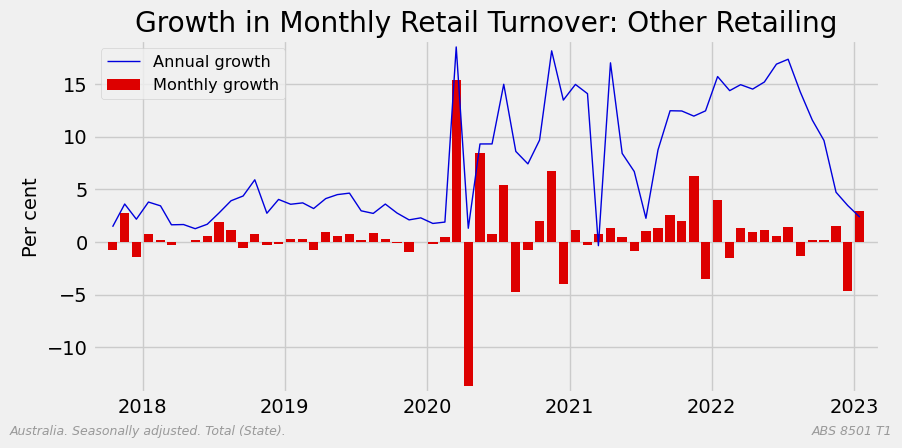

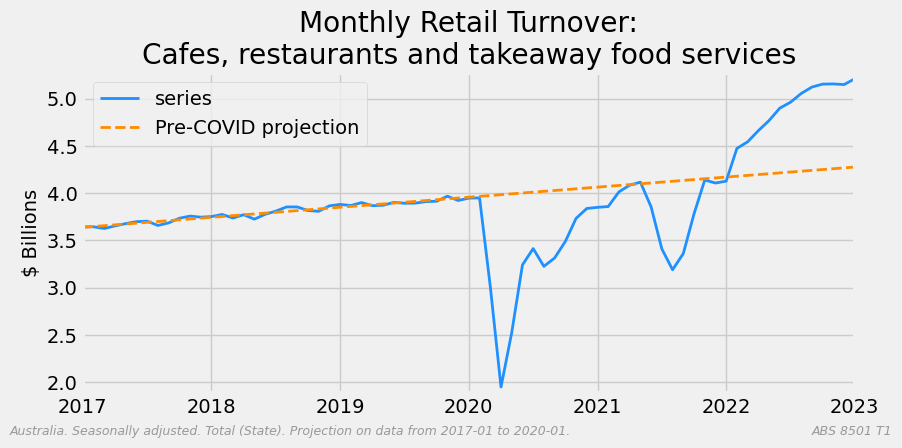

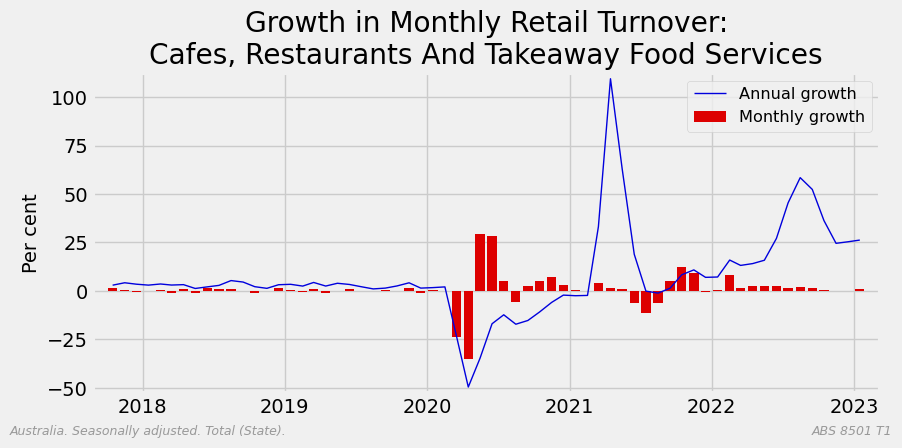

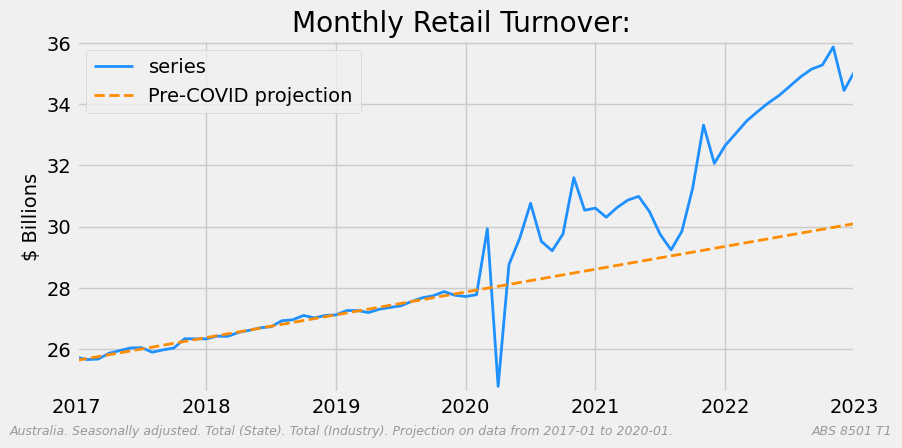

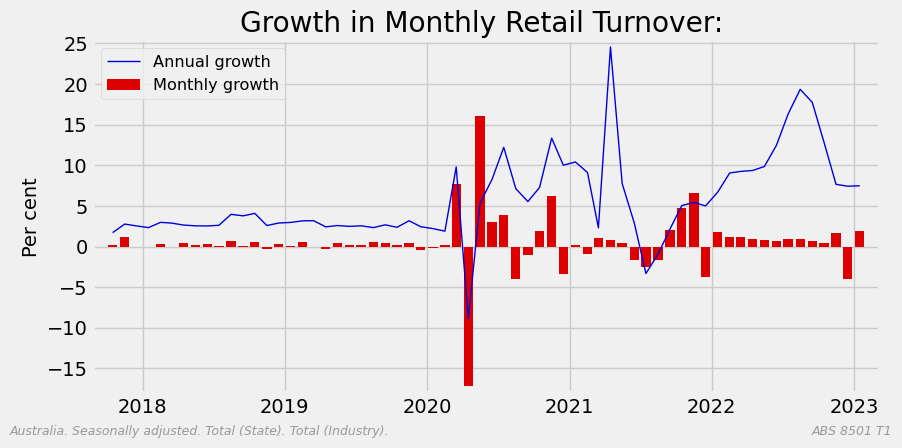

In [5]:
table = "1"
data = retail_dict[table]
series_type = "Seasonally Adjusted"
rows = retail_meta[
    retail_meta[did_col].str.contains("Turnover", regex="False")
    & retail_meta[unit_col].str.contains("$", regex="False")
    # & (retail_meta[table_col] == table)
    & (retail_meta[type_col] == series_type)
]

recent = plot_times[1]
for index, row in rows.iterrows():
    # get the data for wacg poltable item
    series_id, units, table = row[id_col], row[unit_col], row[table_col]
    data = retail_dict[table]
    series, units = recalibrate_series(data[series_id], units)
    check = pd.Period("2017-01-01", freq=series.index.freqstr)
    if len(series[series.index > check]) != len(series[series.index > check].dropna()):
        print(f"Odd or missing data: {row[did_col]}")
        continue

    # plot the data
    HEADLINE = '!'
    pre_tag = HEADLINE if table in ['1', '7'] else ''
    series.name = "series"
    frequency = {"Q": "Quarterly", "M": "Monthly"}[series.index.freqstr[0]]
    lfooter = f"Australia. {series_type.capitalize()}. "
    title, lfooter = fix_title(row[did_col], lfooter)
    separator = "\n" if len(title) > LONG_LABEL else " "
    title = f"{frequency} Retail Turnover:{separator}{title.replace('Turnover', '').strip()}"

    plot_covid_recovery(
        series,
        title=title,
        ylabel=units,
        pre_tag=pre_tag,
        rfooter=f"{source} T{table}",
        lfooter=lfooter,
        show=pre_tag == HEADLINE,
    )
    
    if pre_tag == HEADLINE:
        # Only do growth charts on headline items
        growth = calc_growth(series)
        plot_growth_finalise(
            *growth,
            from_=pd.Period(recent, freq=series.index.freqstr[0]),
            title=f"Growth in {title.title()}",
            pre_tag=HEADLINE,
            rfooter=f"{source} T{table}",
            lfooter=lfooter,
            show=True,
        )

## Finished

In [6]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Tue Feb 28 2023 21:42:08

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.10.0

pandas    : 1.5.3
matplotlib: 3.7.0
sys       : 3.11.0 | packaged by conda-forge | (main, Jan 15 2023, 05:44:48) [Clang 14.0.6 ]

Watermark: 2.3.1



In [7]:
print("Finished")

Finished
